In [3]:
# Si estás en Colab o una venv limpia, descomenta:#
#!pip install -U autogluon==1.4.0 pandas pyarrow matplotlib

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

# Parámetros por defecto (puedes cambiarlos aquí o desde el módulo interactivo final)
CSV_PATH        = "/content/coffee_clean.csv"
YEAR_TO_PREDICT = int(os.getenv("PRED_YEAR", "2021"))

RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
pd.set_option("display.max_rows", 200)


In [4]:
def load_and_check_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]

    required = {"year", "country", "type", "consumption", "price", "profit"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Faltan columnas requeridas: {missing}")

    df = df.dropna(subset=list(required)).copy()
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    df = df.dropna(subset=["year"]).copy()
    df["year"] = df["year"].astype(int)

    # Normaliza strings
    for c in ["country", "type"]:
        df[c] = df[c].astype(str).str.strip()

    print("✅ CSV cargado:", path)
    print("Rango años:", int(df["year"].min()), "→", int(df["year"].max()))
    print("Filas:", len(df), "| Países:", df["country"].nunique(), "| Tipos:", df["type"].unique().tolist())
    return df

df_raw = load_and_check_csv(CSV_PATH)
df_raw.head()


✅ CSV cargado: /content/coffee_clean.csv
Rango años: 1991 → 2020
Filas: 1650 | Países: 55 | Tipos: ['Robusta/Arabica', 'Arabica', 'Arabica/Robusta', 'Robusta']


,country,type,consumption,year,price,revenue,profit,margin,market_share
0,Angola,Robusta/Arabica,1200000,1991,87.686363,1.052236e+08,1.051303e+08,0.999113,0.001025
1,Angola,Robusta/Arabica,1800000,1992,87.686363,1.578355e+08,1.577121e+08,0.999219,0.001483
2,Angola,Robusta/Arabica,2100000,1993,87.686363,1.841414e+08,1.840030e+08,0.999249,0.001671
3,Angola,Robusta/Arabica,1200000,1994,87.686363,1.052236e+08,1.051303e+08,0.999113,0.000948
4,Angola,Robusta/Arabica,1500000,1995,87.686363,1.315295e+08,1.314212e+08,0.999176,0.001170


In [5]:
ALL_COUNTRIES = "__ALL_COUNTRIES__"
ALL_TYPES     = "__ALL_TYPES__"

def aggregate_optional(df: pd.DataFrame, country: str | None, coffee_type: str | None) -> pd.DataFrame:
    """
    Si country es None → agrupa sobre todos los países como 'precio internacional'.
    Si coffee_type es None → agrupa sobre todos los tipos.
    Para 'price' usa un promedio ponderado por 'consumption' cuando agregamos.
    Para 'consumption' y 'profit' usa suma.
    """
    work = df.copy()
    # Normaliza filtros a lower()
    country = country.strip() if isinstance(country, str) and country.strip() else None
    coffee_type = coffee_type.strip() if isinstance(coffee_type, str) and coffee_type.strip() else None

    if country is not None:
        work = work[work["country"].str.lower() == country.lower()]
    if coffee_type is not None:
        work = work[work["type"].str.lower() == coffee_type.lower()]

    # Determina llaves de agrupación
    group_keys = ["year"]
    country_key = "country" if country is not None else "all_country"
    type_key    = "type"    if coffee_type is not None else "all_type"

    if country is not None:
        work["all_country"] = work["country"]
    else:
        work["all_country"] = ALL_COUNTRIES

    if coffee_type is not None:
        work["all_type"] = work["type"]
    else:
        work["all_type"] = ALL_TYPES

    group_keys += ["all_country", "all_type"]

    # Agregaciones:
    #   - consumption: suma
    #   - profit: suma
    #   - price: promedio ponderado por consumo (si hay consumo>0), si no, promedio simple
    def agg_fun(g):
        total_cons = g["consumption"].sum()
        if total_cons > 0:
            price_w = (g["price"] * g["consumption"]).sum() / total_cons
        else:
            price_w = g["price"].mean()
        return pd.Series({
            "consumption": total_cons,
            "profit": g["profit"].sum(),
            "price": price_w
        })

    agg = work.groupby(group_keys, as_index=False).apply(agg_fun)

    # Renombra columnas y genera item_id
    agg = agg.rename(columns={
        "all_country": "country",
        "all_type": "type"
    })
    agg["item_id"] = agg["country"].astype(str) + "|" + agg["type"].astype(str)
    agg["timestamp"] = pd.to_datetime(agg["year"].astype(str) + "-01-01")

    # Ordena
    agg = agg.sort_values(["country", "type", "year"]).reset_index(drop=True)
    return agg

In [6]:
def to_ts(
    df: pd.DataFrame,
    target_col: str,
    extra_known_covariates: list | None = None,
    add_static_features: bool = True
) -> TimeSeriesDataFrame:
    use_cols = ["item_id", "timestamp", target_col]
    if extra_known_covariates:
        use_cols += extra_known_covariates

    tmp = df[use_cols].copy().rename(columns={target_col: "target"})

    ts = TimeSeriesDataFrame.from_data_frame(
        tmp,
        id_column="item_id",
        timestamp_column="timestamp",
    )

    if add_static_features:
        static_df = df[["item_id", "country", "type"]].drop_duplicates().set_index("item_id")
        ts.static_features = static_df

    return ts


In [7]:
def fit_consumption_model(df_series: pd.DataFrame) -> TimeSeriesPredictor:
    ts = to_ts(df_series, target_col="consumption")
    predictor = TimeSeriesPredictor(
        target="target",
        prediction_length=1,
    ).fit(
        ts,
        hyperparameters={
            "Chronos": [{
                "model_path": "bolt_small",
                "fine_tune": True,
                "ag_args": {"name_suffix": "FT"},
            }],
            "ETS": {},
            "SeasonalNaive": {},
        },
        enable_ensemble=False,
        time_limit=600,
    )
    return predictor

def fit_price_model(df_series: pd.DataFrame) -> TimeSeriesPredictor:
    # Usa consumo como covariable conocida
    ts = to_ts(df_series, target_col="price", extra_known_covariates=["consumption"])
    predictor = TimeSeriesPredictor(
        target="target",
        prediction_length=1,
        known_covariates_names=["consumption"],
    ).fit(
        ts,
        hyperparameters={
            "Chronos": [{
                "model_path": "bolt_small",
                "fine_tune": True,
                "covariate_regressor": "CAT",
                "target_scaler": "standard",
                "ag_args": {"name_suffix": "WithReg"},
            }],
            "ETS": {},
            "SeasonalNaive": {},
        },
        enable_ensemble=False,
        time_limit=900,
    )
    return predictor

def fit_profit_model(df_series: pd.DataFrame) -> TimeSeriesPredictor:
    # Usa consumo y precio como covariables conocidas
    ts = to_ts(df_series, target_col="profit", extra_known_covariates=["consumption", "price"])
    predictor = TimeSeriesPredictor(
        target="target",
        prediction_length=1,
        known_covariates_names=["consumption", "price"],
    ).fit(
        ts,
        hyperparameters={
            "Chronos": [{
                "model_path": "bolt_small",
                "fine_tune": True,
                "covariate_regressor": "CAT",
                "target_scaler": "standard",
                "ag_args": {"name_suffix": "WithReg"},
            }],
            "ETS": {},
            "SeasonalNaive": {},
        },
        enable_ensemble=False,
        time_limit=900,
    )
    return predictor


In [8]:
def predict_one_year(predictor: TimeSeriesPredictor,
                     hist_ts: TimeSeriesDataFrame,
                     year: int,
                     known_cov_ts: TimeSeriesDataFrame | None = None) -> pd.DataFrame:
    fcst = predictor.predict(hist_ts, known_covariates=known_cov_ts)
    out = fcst.to_data_frame().reset_index()
    return out[out["timestamp"].dt.year == year][["item_id", "timestamp", "mean"]]

In [11]:
def full_pipeline(df_all: pd.DataFrame,
                  year_to_predict: int,
                  country: str | None,
                  coffee_type: str | None,
                  targets: list[str]):
    """
    targets ∈ {'consumption','price','profit'} (uno o varios)
    Devuelve dict con DataFrames de predicción por target.
    """
    # 1) Agregar según filtros
    df_series = aggregate_optional(df_all, country, coffee_type)

    if (df_series["year"] == year_to_predict).any():
        raise ValueError(f"El año {year_to_predict} YA existe en la serie agregada. "
                         "Cámbialo o excluye ese año del histórico.")

    results = {}
    cache_cov = {}

    # 2) CONSUMPTION
    if "consumption" in targets or "price" in targets or "profit" in targets:
        cons_pred = fit_consumption_model(df_series)
        cons_ts   = to_ts(df_series, target_col="consumption")
        cons_y    = predict_one_year(cons_pred, cons_ts, year_to_predict).rename(columns={"mean": "consumption"})
        results["consumption"] = cons_y.copy()
        cache_cov["consumption"] = cons_y.copy()

    # 3) PRICE (requiere consumo futuro)
    if "price" in targets or "profit" in targets:
        price_pred = fit_price_model(df_series)
        price_ts   = to_ts(df_series, target_col="price", extra_known_covariates=["consumption"])
        # Construir known_covariates para el paso futuro (usar reset_index() directamente)
        template = price_pred.make_future_data_frame(price_ts).reset_index()[["item_id", "timestamp"]]
        known_cov = template.merge(cache_cov["consumption"], on=["item_id", "timestamp"], how="left")
        known_cov_ts = TimeSeriesDataFrame.from_data_frame(known_cov, id_column="item_id", timestamp_column="timestamp")
        price_y  = predict_one_year(price_pred, price_ts, year_to_predict, known_cov_ts).rename(columns={"mean": "price"})
        results["price"] = price_y.copy()
        cache_cov["price"] = price_y.copy()

    # 4) PROFIT (requiere consumo y precio futuros)
    if "profit" in targets:
        profit_pred = fit_profit_model(df_series)
        profit_ts   = to_ts(df_series, target_col="profit", extra_known_covariates=["consumption", "price"])
        template = profit_pred.make_future_data_frame(profit_ts).reset_index()[["item_id", "timestamp"]]
        known_cov = template.merge(cache_cov["consumption"], on=["item_id", "timestamp"], how="left")
        known_cov = known_cov.merge(cache_cov["price"], on=["item_id", "timestamp"], how="left")
        known_cov_ts = TimeSeriesDataFrame.from_data_frame(known_cov, id_column="item_id", timestamp_column="timestamp")
        profit_y = predict_one_year(profit_pred, profit_ts, year_to_predict, known_cov_ts).rename(columns={"mean": "profit"})
        results["profit"] = profit_y.copy()

    # 5) Añade metadatos legibles
    meta = df_series[["item_id", "country", "type"]].drop_duplicates()
    for k, dfk in results.items():
        dfk["year"] = dfk["timestamp"].dt.year
        results[k] = dfk.merge(meta, on="item_id", how="left")[["country", "type", "year", k]]

    return results

In [12]:
# Ejemplo: predecir los 3 targets para precio internacional (todos los países) y todos los tipos
example_targets = ["consumption", "price", "profit"]
res = full_pipeline(df_raw, YEAR_TO_PREDICT, country=None, coffee_type=None, targets=example_targets)

for k, dfk in res.items():
    print(f"\n=== Predicción {k.upper()} para {YEAR_TO_PREDICT} ===")
    display(dfk)


/tmp/ipython-input-3531314526.py:54: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = work.groupby(group_keys, as_index=False).apply(agg_fun)
Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/AutogluonModels/ag-20250907_132647'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          1
Memory Avail:       10.07 GB / 12.67 GB (79.5%)
Disk Space Avail:   66.36 GB / 112.64 GB (58.9%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric':


=== Predicción CONSUMPTION para 2021 ===


,country,type,year,consumption
0,__ALL_COUNTRIES__,__ALL_TYPES__,2021,2.998891e+09



=== Predicción PRICE para 2021 ===


,country,type,year,price
0,__ALL_COUNTRIES__,__ALL_TYPES__,2021,110.60908



=== Predicción PROFIT para 2021 ===


,country,type,year,profit
0,__ALL_COUNTRIES__,__ALL_TYPES__,2021,3.315530e+11


In [13]:
def save_results(res_dict: dict, year_to_predict: int, suffix: str = ""):
    paths = {}
    for k, dfk in res_dict.items():
        fname = f"forecast_{k}_{year_to_predict}{suffix}.csv"
        dfk.to_csv(fname, index=False, encoding="utf-8")
        paths[k] = fname
        print("💾 Guardado:", fname)
    return paths

_ = save_results(res, YEAR_TO_PREDICT)


💾 Guardado: forecast_consumption_2021.csv
💾 Guardado: forecast_price_2021.csv
💾 Guardado: forecast_profit_2021.csv


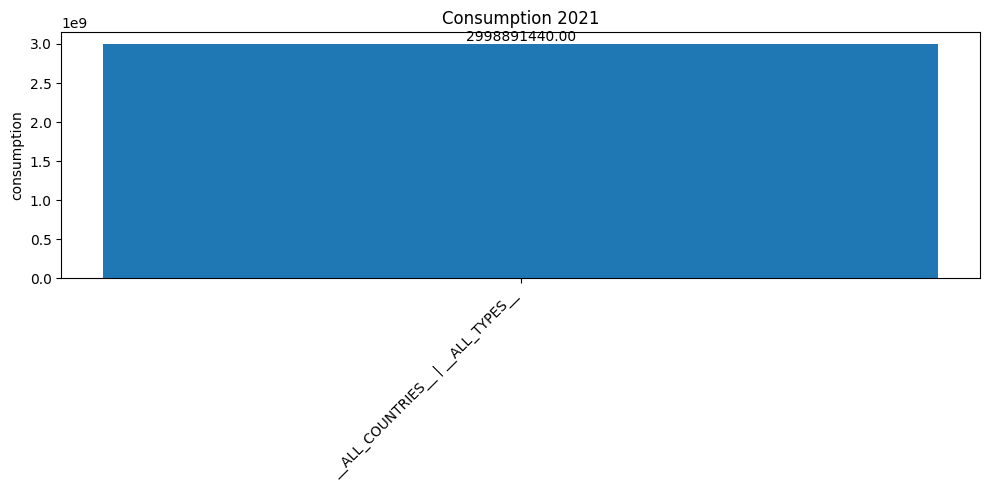

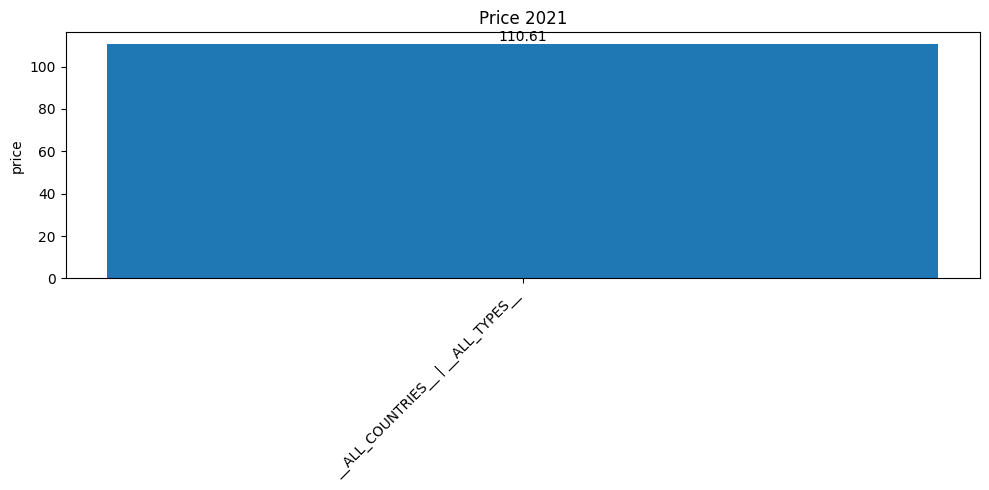

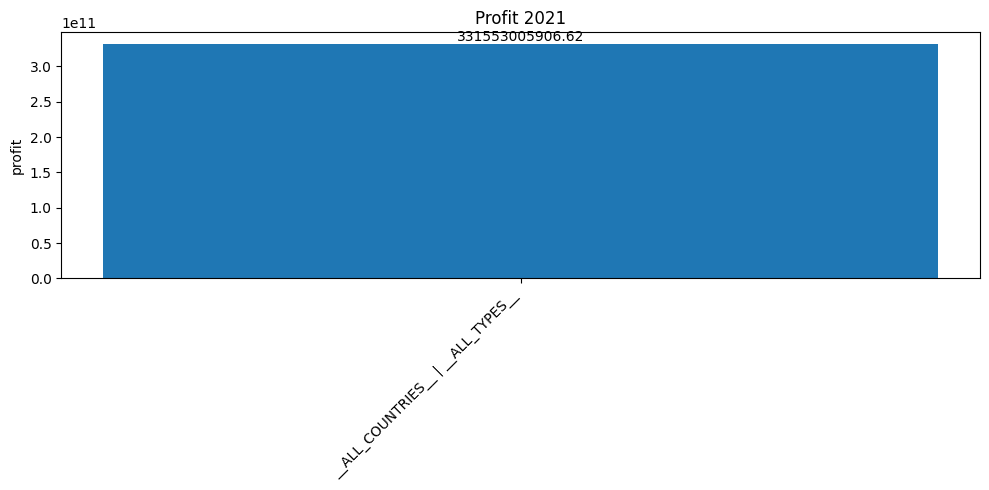

In [14]:
def bar_with_labels(df_plot: pd.DataFrame, value_col: str, title: str):
    order = "country" if "country" in df_plot.columns else None
    if order:
        df_plot = df_plot.sort_values(order)
    x = np.arange(len(df_plot))
    y = df_plot[value_col].values
    labels = df_plot["country"].astype(str) + " | " + df_plot["type"].astype(str)

    plt.figure(figsize=(10,5))
    plt.bar(x, y)
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel(value_col)
    plt.title(title)
    for xi, yi in zip(x, y):
        plt.text(xi, yi, f"{yi:.2f}", ha="center", va="bottom")
    plt.tight_layout()
    plt.show()

# Ejemplos:
for k, dfk in res.items():
    bar_with_labels(dfk, value_col=k, title=f"{k.capitalize()} {YEAR_TO_PREDICT}")


In [24]:
def ask_user_and_predict(df_all: pd.DataFrame):
    print("=== Asistente de predicción de café ===")
    year_str = input("Año a predecir (por ejemplo 2021): ").strip()
    if not year_str.isdigit():
        raise ValueError("El año debe ser numérico.")
    year_to_predict = int(year_str)

    print("\n¿Qué objetivo(s) quieres predecir?")
    print("  1) consumo")
    print("  2) precio")
    print("  3) profit")
    print("  Puedes separar con comas (ej: 1,2,3).")
    obj_raw = input("Elige: ").strip()
    mapping = {"1":"consumption", "2":"price", "3":"profit",
               "consumo":"consumption", "consumption":"consumption",
               "precio":"price", "price":"price",
               "utilidad":"profit", "profit":"profit"}
    chosen = []
    for tok in [t.strip().lower() for t in obj_raw.replace(";",",").split(",") if t.strip()]:
        if tok in mapping:
            chosen.append(mapping[tok])
    chosen = list(dict.fromkeys(chosen))  # únicos, preserva orden
    if not chosen:
        raise ValueError("No se seleccionó ningún objetivo válido.")

    print("\nFiltros (dejar vacío para agrupar todos):")
    country = input("País (opcional, vacío = precio internacional): ").strip()
    country = country if country else None
    ctype   = input("Tipo (opcional, vacío = todos los tipos): ").strip()
    ctype   = ctype if ctype else None

    print("\nEntrenando y prediciendo…")
    results = full_pipeline(df_all, year_to_predict, country, ctype, chosen)

    # Mostrar y guardar
    for k, dfk in results.items():
        print(f"\n=== Predicción {k.upper()} {year_to_predict} ===")
        display(dfk)

    save_results(results, year_to_predict, suffix=f"_{(country or 'ALL')}_{(ctype or 'ALL')}")
    print("\n✅ Listo.")

# Ejecuta el asistente:
ask_user_and_predict(df_raw)

=== Asistente de predicción de café ===
Año a predecir (por ejemplo 2021): 2021

¿Qué objetivo(s) quieres predecir?
  1) consumo
  2) precio
  3) profit
  Puedes separar con comas (ej: 1,2,3).
Elige: 1

Filtros (dejar vacío para agrupar todos):
País (opcional, vacío = precio internacional): Angola
Tipo (opcional, vacío = todos los tipos): 


/tmp/ipython-input-3531314526.py:54: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = work.groupby(group_keys, as_index=False).apply(agg_fun)
Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/AutogluonModels/ag-20250907_134736'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          1
Memory Avail:       10.10 GB / 12.67 GB (79.7%)
Disk Space Avail:   65.30 GB / 112.64 GB (58.0%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric':


Entrenando y prediciendo…


	Saving fine-tuned model to /content/AutogluonModels/ag-20250907_134736/models/ChronosFT[bolt_small]/W0/fine-tuned-ckpt
	-0.0048       = Validation score (-WQL)
	97.18   s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training complete. Models trained: ['SeasonalNaive', 'ETS', 'ChronosFT[bolt_small]']
Total runtime: 97.26 s
Best model: ChronosFT[bolt_small]
Best model score: -0.0048
Model not specified in predict, will default to the model with the best validation score: ChronosFT[bolt_small]



=== Predicción CONSUMPTION 2021 ===


,country,type,year,consumption
0,Angola,__ALL_TYPES__,2021,1795217.875


💾 Guardado: forecast_consumption_2021_Angola_ALL.csv

✅ Listo.


In [16]:
def sanity_checks(df_all: pd.DataFrame):
    print("Longitudes por (country|type):")
    display(df_all.groupby(["country","type"]).size().describe())
    # Años por cada serie:
    lens = df_all.groupby(["country","type"])["year"].nunique().describe()
    print("Años únicos por serie - resumen:")
    print(lens)

sanity_checks(df_raw)

Longitudes por (country|type):


,0
count,55.0
mean,30.0
std,0.0
min,30.0
25%,30.0
50%,30.0
75%,30.0
max,30.0


Años únicos por serie - resumen:
count    55.0
mean     30.0
std       0.0
min      30.0
25%      30.0
50%      30.0
75%      30.0
max      30.0
Name: year, dtype: float64
